In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This is derived from RunModel_Demo_02June2020-SimpleCNNLayer_Ca

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.

The 04Feb2021 version of the code is intended to train the same model, but using the KDE_A kernels rather than the original kernels.  The purpose is to test the code that reads in the KDE.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Fri Feb  5 19:29:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   35C    P8    39W / 250W |   5636MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path


### Set up local parameters

In [4]:
n_epochs = 50


folder = '05February2021_AllCNN6Layer_Ca_iter0_50epochs_poca_KDE_A_lr_1em3_loss_1p0_4xwill'
name = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 128

# How fast to learn
learning_rate = 1e-3

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_poca_KDE import collect_data_poca

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below


##from model.models_mds_G import SimpleCNN5Layer_Ca as Model
from model.models_mds_G import AllCNN6Layer_Ca as Model

from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features

train_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                                 '/share/lazy/will/data/June30_2020_80k_2.h5',
                                 '/share/lazy/will/data/June30_2020_80k_3.h5',
                                 '/share/lazy/will/data/June30_2020_80k_4.h5',
                            batch_size=batch_size,
                           ## device=device,
                            masking=True, shuffle=True,
                           ## slice = slice(0,18000)
                           )

val_loader = collect_data_poca('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                           ## device=device,
                            masking=True, shuffle=True,
                            ##slice = slice(18000,None)
                           )



Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 12.09 s
Loaded /share/lazy/will/data/June30_2020_80k_2.h5 in 12.6 s
Loaded /share/lazy/will/data/June30_2020_80k_3.h5 in 12.83 s
Loaded /share/lazy/will/data/June30_2020_80k_4.h5 in 12.82 s
Constructing 320000 event dataset took 2.175 s
Loading data...
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 2.987 s
Constructing 20000 event dataset took 0.08346 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
model = Model()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 10:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ct, child =  0    Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
     About to set param.requires_grad=False for ct =  0 params
ct, child =  1    Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
     About to set param.requires_grad=False for ct =  1 params
ct, child =  2    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
     About to set param.requires_grad=False for ct =  2 params
ct, child =  3    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
     About to set param.requires_grad=False for ct =  3 params
ct, child =  4    Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
     About to set param.requires_grad=False for ct =  4 params
ct, child =  5    Dropout(p=0.15, inplace=False)
     About to set param.requires_grad=False for ct =  5 params
ct, child =  6    Dropout(p=0.15, inplace=False)
     About to set param.requires_grad=False for ct =  6 params
ct, child =  7    Dropout(p=0.15, inplace=False)
     About to set p

In [11]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [12]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
d_name = '04February2021_SimpleCNN5Layer_Ca_iter3_600epochs_poca_KDE_A_lr_3em4_loss_1p0_4xwill'
d_folder = d_name
suffix = 'final'
dict_name = 'ML/'+d_folder+'/'+d_name+'_'+suffix+'.pyt'
print("pretrained dict_name = ",dict_name)
pretrained_dict = torch.load(dict_name)


model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
print(" \n","  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
## mds  

print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
## print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


output =  ML/05February2021_AllCNN6Layer_Ca_iter0_50epochs_poca_KDE_A_lr_1em3_loss_1p0_4xwill
pretrained dict_name =  ML/04February2021_SimpleCNN5Layer_Ca_iter3_600epochs_poca_KDE_A_lr_3em4_loss_1p0_4xwill/04February2021_SimpleCNN5Layer_Ca_iter3_600epochs_poca_KDE_A_lr_3em4_loss_1p0_4xwill_final.pyt
for model_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4.weight
index, k =   7    conv4.bias
index, k =   8    conv5.weight
index, k =   9    conv5.bias
index, k =   10    finalFilter.weight
index, k =   11    finalFilter.bias
 
   for pretrained_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4.weight
index, k =   7    conv4.bias
index, k =   8    conv5.weight
index, k =   9

_IncompatibleKeys(missing_keys=['finalFilter.weight', 'finalFilter.bias'], unexpected_keys=[])

In [13]:
model = model.to(device)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


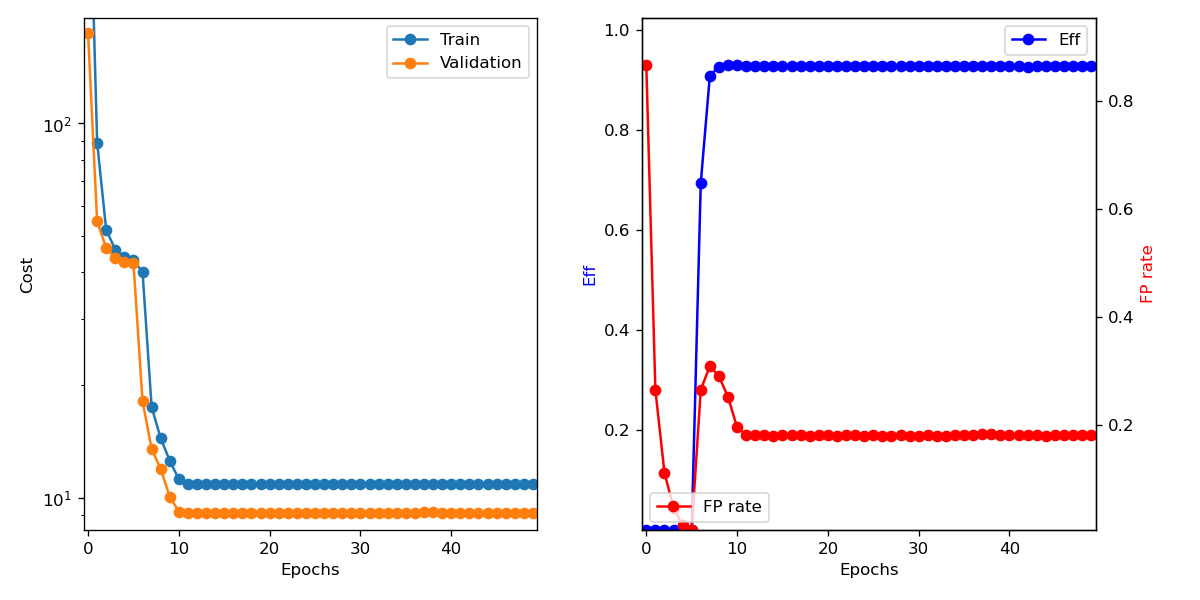

In [14]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [15]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 2500, val = 157


Epoch 0: train=688.319, val=174.035, took 30.928 s
  Validation Found 17 of 108007, added 17341 (eff 0.02%) (0.867 FP/event)


Epoch 1: train=88.9281, val=54.7279, took 24.029 s
  Validation Found 9 of 108007, added 5291 (eff 0.01%) (0.265 FP/event)


Epoch 2: train=51.9648, val=46.4943, took 23.574 s
  Validation Found 7 of 108007, added 2224 (eff 0.01%) (0.111 FP/event)


Epoch 3: train=45.9951, val=43.5957, took 24.621 s
  Validation Found 7 of 108007, added 921 (eff 0.01%) (0.046 FP/event)


Epoch 4: train=43.8646, val=42.7573, took 24.048 s
  Validation Found 9 of 108007, added 277 (eff 0.01%) (0.0138 FP/event)


Epoch 5: train=43.0536, val=42.4615, took 24.429 s
  Validation Found 15 of 108007, added 109 (eff 0.01%) (0.00545 FP/event)


Epoch 6: train=40.127, val=18.0942, took 24.263 s
  Validation Found 74986 of 108007, added 5306 (eff 69.43%) (0.265 FP/event)


Epoch 7: train=17.4976, val=13.5013, took 24.803 s
  Validation Found 98127 of 108007, added 6165 (eff 90.85%) (0.308 FP/event)


Epoch 8: train=14.3986, val=11.9137, took 24.777 s
  Validation Found 100113 of 108007, added 5805 (eff 92.69%) (0.29 FP/event)


Epoch 9: train=12.5484, val=10.0476, took 23.055 s
  Validation Found 100552 of 108007, added 5031 (eff 93.10%) (0.252 FP/event)


Epoch 10: train=11.1888, val=9.17601, took 23.251 s
  Validation Found 100383 of 108007, added 3908 (eff 92.94%) (0.195 FP/event)


Epoch 11: train=10.8631, val=9.1174, took 23.331 s
  Validation Found 100198 of 108007, added 3619 (eff 92.77%) (0.181 FP/event)


Epoch 12: train=10.8509, val=9.11651, took 22.967 s
  Validation Found 100192 of 108007, added 3616 (eff 92.76%) (0.181 FP/event)


Epoch 13: train=10.8556, val=9.10686, took 23.291 s
  Validation Found 100151 of 108007, added 3625 (eff 92.73%) (0.181 FP/event)


Epoch 14: train=10.8562, val=9.09677, took 23.339 s
  Validation Found 100132 of 108007, added 3590 (eff 92.71%) (0.179 FP/event)


Epoch 15: train=10.853, val=9.10655, took 24.293 s
  Validation Found 100138 of 108007, added 3604 (eff 92.71%) (0.18 FP/event)


Epoch 16: train=10.8567, val=9.11515, took 24.286 s
  Validation Found 100183 of 108007, added 3627 (eff 92.76%) (0.181 FP/event)


Epoch 17: train=10.8574, val=9.11751, took 24.336 s
  Validation Found 100197 of 108007, added 3636 (eff 92.77%) (0.182 FP/event)


Epoch 18: train=10.8531, val=9.10352, took 24.05 s
  Validation Found 100147 of 108007, added 3589 (eff 92.72%) (0.179 FP/event)


Epoch 19: train=10.8628, val=9.11033, took 23.912 s
  Validation Found 100180 of 108007, added 3610 (eff 92.75%) (0.18 FP/event)


Epoch 20: train=10.8606, val=9.11829, took 23.854 s
  Validation Found 100205 of 108007, added 3620 (eff 92.78%) (0.181 FP/event)


Epoch 21: train=10.8587, val=9.1061, took 23.901 s
  Validation Found 100161 of 108007, added 3590 (eff 92.74%) (0.179 FP/event)


Epoch 22: train=10.8571, val=9.10804, took 23.87 s
  Validation Found 100176 of 108007, added 3611 (eff 92.75%) (0.181 FP/event)


Epoch 23: train=10.8553, val=9.11421, took 23.943 s
  Validation Found 100181 of 108007, added 3626 (eff 92.75%) (0.181 FP/event)


Epoch 24: train=10.8529, val=9.11367, took 24.144 s
  Validation Found 100187 of 108007, added 3596 (eff 92.76%) (0.18 FP/event)


Epoch 25: train=10.8569, val=9.1131, took 23.898 s
  Validation Found 100179 of 108007, added 3616 (eff 92.75%) (0.181 FP/event)


Epoch 26: train=10.8533, val=9.09563, took 24.286 s
  Validation Found 100145 of 108007, added 3583 (eff 92.72%) (0.179 FP/event)


Epoch 27: train=10.8556, val=9.09763, took 24.18 s
  Validation Found 100138 of 108007, added 3592 (eff 92.71%) (0.18 FP/event)


Epoch 28: train=10.855, val=9.11083, took 24.854 s
  Validation Found 100165 of 108007, added 3610 (eff 92.74%) (0.18 FP/event)


Epoch 29: train=10.8581, val=9.11046, took 24.323 s
  Validation Found 100188 of 108007, added 3596 (eff 92.76%) (0.18 FP/event)


Epoch 30: train=10.8535, val=9.10869, took 24.262 s
  Validation Found 100176 of 108007, added 3594 (eff 92.75%) (0.18 FP/event)


Epoch 31: train=10.858, val=9.10433, took 23.901 s
  Validation Found 100147 of 108007, added 3610 (eff 92.72%) (0.18 FP/event)


Epoch 32: train=10.86, val=9.10825, took 24.8 s
  Validation Found 100164 of 108007, added 3602 (eff 92.74%) (0.18 FP/event)


Epoch 33: train=10.8571, val=9.10573, took 25.218 s
  Validation Found 100147 of 108007, added 3594 (eff 92.72%) (0.18 FP/event)


Epoch 34: train=10.8593, val=9.11187, took 24.416 s
  Validation Found 100176 of 108007, added 3607 (eff 92.75%) (0.18 FP/event)


Epoch 35: train=10.8525, val=9.11493, took 24.432 s
  Validation Found 100193 of 108007, added 3610 (eff 92.77%) (0.18 FP/event)


Epoch 36: train=10.8555, val=9.10476, took 24.317 s
  Validation Found 100155 of 108007, added 3607 (eff 92.73%) (0.18 FP/event)


Epoch 37: train=10.8609, val=9.12312, took 23.954 s
  Validation Found 100204 of 108007, added 3642 (eff 92.78%) (0.182 FP/event)


Epoch 38: train=10.8586, val=9.12424, took 24.048 s
  Validation Found 100221 of 108007, added 3654 (eff 92.79%) (0.183 FP/event)


Epoch 39: train=10.8555, val=9.11138, took 24.182 s
  Validation Found 100171 of 108007, added 3606 (eff 92.74%) (0.18 FP/event)


Epoch 40: train=10.8543, val=9.10965, took 24.117 s
  Validation Found 100173 of 108007, added 3603 (eff 92.75%) (0.18 FP/event)


Epoch 41: train=10.8587, val=9.11573, took 24.132 s
  Validation Found 100185 of 108007, added 3632 (eff 92.76%) (0.182 FP/event)


Epoch 42: train=10.8535, val=9.09624, took 24.414 s
  Validation Found 100131 of 108007, added 3613 (eff 92.71%) (0.181 FP/event)


Epoch 43: train=10.8548, val=9.11571, took 24.177 s
  Validation Found 100197 of 108007, added 3624 (eff 92.77%) (0.181 FP/event)


Epoch 44: train=10.8576, val=9.09859, took 23.964 s
  Validation Found 100137 of 108007, added 3579 (eff 92.71%) (0.179 FP/event)


Epoch 45: train=10.8577, val=9.10981, took 24.066 s
  Validation Found 100161 of 108007, added 3610 (eff 92.74%) (0.18 FP/event)


Epoch 46: train=10.855, val=9.11129, took 24.108 s
  Validation Found 100168 of 108007, added 3607 (eff 92.74%) (0.18 FP/event)


Epoch 47: train=10.8543, val=9.11322, took 23.862 s
  Validation Found 100166 of 108007, added 3622 (eff 92.74%) (0.181 FP/event)


Epoch 48: train=10.8551, val=9.1195, took 24.101 s
  Validation Found 100210 of 108007, added 3633 (eff 92.78%) (0.182 FP/event)


Epoch 49: train=10.8503, val=9.10782, took 24.39 s
  Validation Found 100152 of 108007, added 3609 (eff 92.73%) (0.18 FP/event)



# Results

Let's save some results: (even though if you have not changed the code above, it saves the model every epoch)

Go ahead and save the final model (even though it was also saved above):

In [16]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [17]:
results.to_hdf(f'{name}_stats.hdf5', 'results')
results.to_hdf(str(output / f'{name}_stats_a.hdf5'),'results')

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


Save the plot above:

<IPython.core.display.Javascript object>


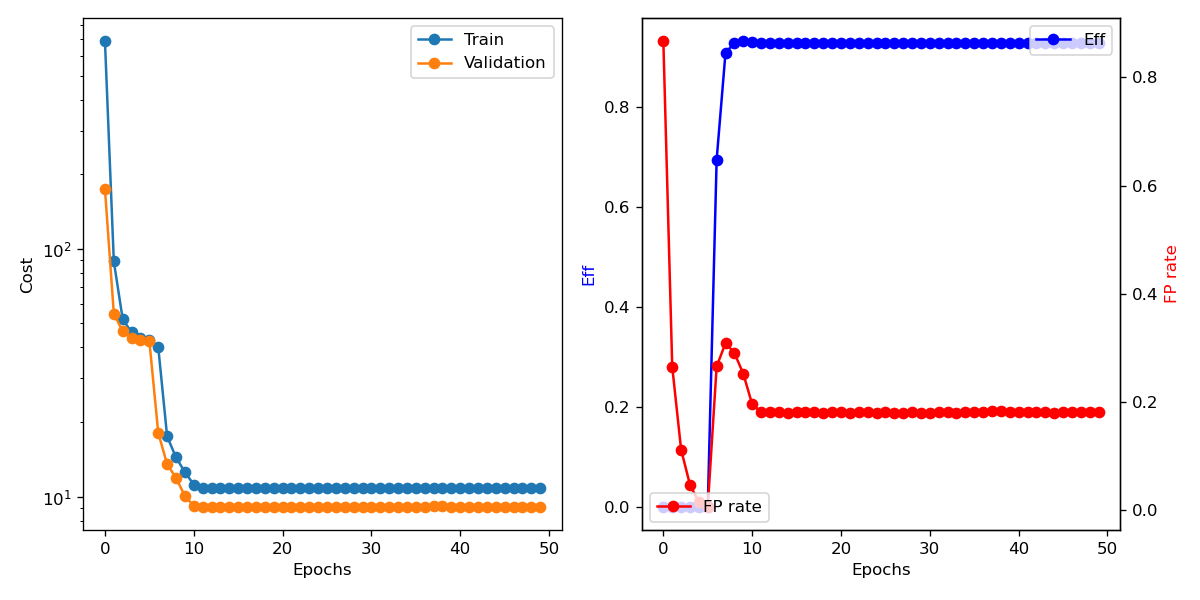

In [18]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [20]:
##quit()